# Developing and testing machine learning strategies

**The purpose of this notebook is to develop and evaluate models for predicting whether a Kickstarter project will be funded based on a campaign section.** 

## Table of contents
1. [Loading the data](#cell1)
2. [Building the design matrix for meta features](#cell2)
3. [Building a design matrix for the $n$-gram model](#cell3)
4. [Preparing the target variable](#cell4)
5. [Evaluating models](#cell5)
7. [Diagnosing the classifier with learning curves](#cell6)
8. [Using nested cross-validation to optimize hyperparameters](#cell7)
9. [Training a validated model](#cell8)
10. [Determining the top predictors of funded projects](#cell9)
11. [Testing Kickstarter pages](#cell10)

<a id="cell1"></a>
## 1. Loading the data

In [1]:
# Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import nltk
import feature_engineering
from scipy import sparse
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    learning_curve, StratifiedShuffleSplit, GridSearchCV, cross_val_score,
    ShuffleSplit, cross_val_predict
)

# Set figure display options
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
sns.set(font_scale=1.3)

The training set for both campaign sections are stored in PostgreSQL databases. Let's begin by loading the credentials to connect to the databases.

In [2]:
# Set database credentials
db_name1 = 'section1_db'
db_name2 = 'section2_db'
usernm = 'redwan'
host = 'localhost'
port = '5432'

Now that we can connect to the databases, we'll query all the data for both campaign sections and store them locally.

In [3]:
# Prepare a connection to database for section 1
con1 = psycopg2.connect(
    database=db_name1, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Prepare a connection for section 2
con2 = psycopg2.connect(
    database=db_name2, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Query all data from both campaign sections
sql_query1 = 'SELECT * FROM section1_db;'
sql_query2 = 'SELECT * FROM section2_db;'
section1_df_full = pd.read_sql_query(sql_query1, con1)
section2_df_full = pd.read_sql_query(sql_query2, con2)

### Regression vs. classification

We can either approach this problem as a classification task and attempt to predict whether a project will be funded or not. Another option is to predict what % of the goal will the project reach and therefore, approach the problem as a regression task. 

Let's start with the latter. To do so, let's define a new target variable that measures what % of the goal was reached for each project in the training set.

In [4]:
# Define a target variable for regression
section1_df_full['percent_funded'] = section1_df_full['pledged'] / \
    section1_df_full['goal']

# Display a few rows
section1_df_full.head(2)

,level_0,index,num_sents,num_words,num_all_caps,percent_all_caps,num_exclms,percent_exclms,num_apple_words,percent_apple_words,...,normalized_text,name,category,hyperlink,currency,pledged,goal,location,funded,percent_funded
0,0,88389,15.0,223.0,0.0,0.0,3.0,0.013453,0.0,0.0,...,I am a numbr year old woman who was a general ...,Help me start my cottage industry ... Bakesale...,Small Batch,https://www.kickstarter.com/projects/138529431...,USD,0.0,10000.0,"Cape Coral, FL",False,0.000000
1,1,190378,15.0,383.0,0.0,0.0,4.0,0.010444,0.0,0.0,...,What happens to a sock that disappears in the ...,The Sock Who Lost His Mate at NY Children's Th...,Musical,https://www.kickstarter.com/projects/987315242...,USD,2600.0,7000.0,"Greenwich Village, Manhattan, NY",False,0.371429


<a id="cell2"></a>
## 2. Building the design matrix for meta features

Let's begin by using the extracted meta features for only the "About this project" section for now.

In [5]:
# List of meta features to use in models
features = ['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
            'num_exclms', 'percent_exclms', 'num_apple_words',
            'percent_apple_words', 'avg_words_per_sent', 'num_paragraphs',
            'avg_sents_per_paragraph', 'avg_words_per_paragraph',
            'num_images', 'num_videos', 'num_youtubes', 'num_gifs',
            'num_hyperlinks', 'num_bolded', 'percent_bolded']

# Select features
X = section1_df_full[features]

# Display the first five rows of the design matrix
X.head()

,num_sents,num_words,num_all_caps,percent_all_caps,num_exclms,percent_exclms,num_apple_words,percent_apple_words,avg_words_per_sent,num_paragraphs,avg_sents_per_paragraph,avg_words_per_paragraph,num_images,num_videos,num_youtubes,num_gifs,num_hyperlinks,num_bolded,percent_bolded
0,15.0,223.0,0.0,0.000000,3.0,0.013453,0.0,0.000000,14.866667,9.0,1.888889,24.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,15.0,383.0,0.0,0.000000,4.0,0.010444,0.0,0.000000,25.533333,5.0,3.000000,76.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,15.0,259.0,17.0,0.065637,0.0,0.000000,1.0,0.003861,17.266667,17.0,0.823529,11.470588,15.0,0.0,0.0,0.0,8.0,0.0,0.000000
3,18.0,431.0,0.0,0.000000,3.0,0.006961,1.0,0.002320,23.944444,3.0,6.000000,143.666667,0.0,0.0,0.0,0.0,2.0,0.0,0.000000
4,23.0,282.0,2.0,0.007092,15.0,0.053191,0.0,0.000000,12.260870,5.0,4.600000,56.600000,1.0,0.0,0.0,0.0,0.0,12.0,0.042553


### Data wrangling

Some of the projects may contain missing values. We need to decide how to deal with these projects since models in Scikit-learn cannot interpret them.

One strategy is to first remove all projects that have no data. These projects are most likely those that failed to complete an "About this project" section and can safely be excluded.

In [6]:
# Remove all rows with no data
X_cleaned = X[~X.isnull().all(axis=1)]

For the remaining projects with missing values, we can fill them with zeros. This makes sense since missing values arise as a result of missing data or if the number of words in the section is zero. This latter result may have caused a `DivisionByZeroError` during feature engineering but we addressed it by setting those features to `NaN`.

In [7]:
# Fill remaining missing values with zero
X_cleaned = X_cleaned.fillna(0)

## Considering the "Risks and challenges" section

I noticed that some Kickstarter projects don't have a "Risks and challenges" section so let's determine what proportion of projects this represents by defining a new feature called `risks_present` that computes stores a value of 1 if the section is present, otherwise a 0. 

In [8]:
# Identify projects without a 'Risks and challenges' section in risks data
section2_df_full['risks_present'] = ~section2_df_full['normalized_text'] \
    .isnull()

# Select the projects without a 'Risks and challenges' section in about data
section1_df_full = section1_df_full.merge(
    section2_df_full[['index', 'risks_present']],
    how='left', 
    on='index'
)

# Compute the proportion of projects missing a 'Risks and challenges' section
(len(section1_df_full) - section1_df_full['risks_present'].sum()) / \
    len(section1_df_full)

0.22762439938105708

That's concerning&mdash;nearly 23% of projects are missing a "Risks and challenges" section. Let's compare this to the number of projects missing an "About this project" section.

In [9]:
(len(section1_df_full) - len(X_cleaned)) / len(section1_df_full)

0.0012623177783207102

It looks like almost every project has an "About this project" section. After some digging, I discovered that the "Risks and challenges" became mandatory only a few years ago. Since there have been many successful projects in the past that didn't have this section, such as the original [Pebble](https://www.kickstarter.com/projects/getpebble/pebble-e-paper-watch-for-iphone-and-android/description), including this section may skew the model. Therefore, I've elected to focus the model *only* on the "About this project" section.

### Standardizing the meta features

Most machine learning models, besides tree-based models, only function if the features are standardized to have zero mean and unit variance, while others will converge faster. Therefore, let's go ahead and standardize the meta features.

In [10]:
# Standardize the meta features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_cleaned)

<a id="cell3"></a>
## 3. Building a design matrix for the $n$-gram model

We can use the normalized text data from each project's "About this project" section to build an $n$-gram model to determine specific words or pairs of words that are most predictive of funded projects. 

$n$-grams data might pick up noise or convey irrelevant information because they probe into the context of the campaign section, which may include esoteric words or phrases related to the project category. Unfortunately, building a tailored model for the 100+ categories isn't an currently an option! Nevertheless, to build the $n$-gram model, we'll need to perform some additional preprocessing.

1. Remove punctuation
2. Lowercase the text
3. Remove stop words
4. Stem remaining words

In [11]:
def preprocess_text(text):
    # Access stop word dictionary
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Prepare the Porter stemmer
    porter = nltk.PorterStemmer()
    
    # Remove punctuation and lowercase each word
    text = feature_engineering.remove_punc(text).lower()
    
    # Remove stop words and stem each word
    return ' '.join(
        porter.stem(term )
        for term in text.split()
        if term not in set(stop_words)
    )

Let's go ahead and preprocess the campaign section for each project.

In [12]:
# Preprocess text
#preprocessed_text = section1_df_full.loc[X_cleaned.index, 'normalized_text'] \
#    .apply(preprocess_text)

# Alternatively load a pickle that contains the already preprocessed text 
preprocessed_text = joblib.load(
    'data/processed_text-n_grams/preprocessed_text_training_set.pkl'
)

For the $n$-gram model, I've elected to use unigrams and bigrams quantified using the tf-idf statistic and then selecting the top 250 features measured by term frequency. The reason for so few $n$-grams is to a) avoid overfitting and b) allow the model to have less contextual information and enable it to focus on the meta features. 

In [13]:
# Construct a design matrix using an n-gram model and tf-idf statistics
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=250)
#X_ngrams = vectorizer.fit_transform(preprocessed_text)
#joblib.dump(vectorizer, 'vectorizer_250.pkl')
#joblib.dump(X_ngrams, 'X_ngrams_250.pkl')

# Alternatively we can load a pickle that contains the already constructed 
# n-grams and a fitted vectorizer
X_ngrams = joblib.load(
    'data/processed_text-n_grams/X_ngrams_250.pkl'
)

vectorizer = joblib.load(
    'data/processed_text-n_grams/vectorizer_250.pkl'
)

### Combining meta features with $n$-grams

Since the meta features are contained in a Numpy array while the $n$-grams are inside a sparse matrix, we need to convert the former into a sparse matrix and then concatenate them together horizontally.

In [14]:
# Convert the meta features into a sparse matrix
X_std_sparse = sparse.csr_matrix(X_std)

# Concatenate the meta features with the n-grams
X_full = sparse.hstack([X_std_sparse, X_ngrams])

# Display the shape of the combined matrix for confirmation
X_full.shape

(24527, 269)

<a id="cell4"></a>
## 4. Preparing the target variable

Let's select all rows of the regression target variable `percent_funded` that correspond to the rows in the cleaned design matrix.

In [15]:
# Prepare the regression target variable
y_reg = section1_df_full.loc[X_cleaned.index, 'percent_funded'].to_frame()

Let's take a look at the distribution of the regression target variable `percent_funded`.

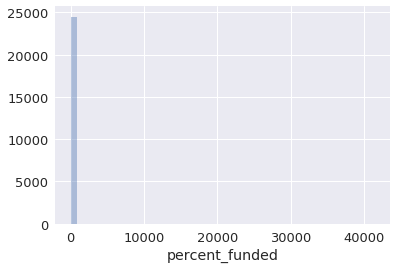

In [16]:
# Display a histogram of the regression target variable
sns.distplot(y_reg['percent_funded'], kde=False);

The histogram is skewed to the right, meaning we have some large outliers. Let's zoom in.

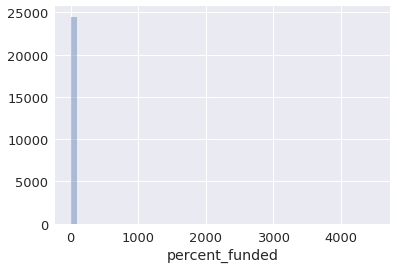

In [17]:
# Display a kde plot of the regression target variable
sns.distplot(
    y_reg[y_reg['percent_funded'] < 5000]['percent_funded'],
    kde=False
);

Let's zoom in further.

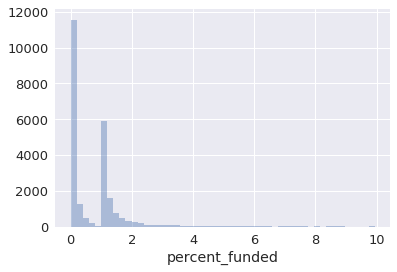

In [18]:
# Display a kde plot of the regression target variable
sns.distplot(
    y_reg[y_reg['percent_funded'] < 10]['percent_funded'],
    kde=False
);

Clearly, the regression target variable has a bimodal distribution. We can't apply regression techniques on the target variable directly. We'd have to potentially separate the two distributions, label them and then perform classification. It might be easier if we just directly use a classification target variable instead.

### Encoding the target variable for classification

For classification tasks, the models in Scikit-learn will work only if the classification target variable is encoded numerically. To do so, let's first select all rows of `funded` that correspond to the rows in the cleaned design matrix.

In [19]:
# Prepare the classification target variable
y = section1_df_full.loc[X_cleaned.index, 'funded'].to_frame()

Before encoding the classification target variable, let's take a peek at the class distribution.

In [20]:
# Display the class distribution
y['funded'].value_counts()

False    13894
True     10633
Name: funded, dtype: int64

The classes are distributed about 3 to 7, which is slightly imbalanced. We'll keep this mind when choosing a performance metric. Finally, let's encode the target variable.

In [21]:
# Encode the class labels in the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

<a id="cell5"></a>
## 5. Evaluating models

We'll approach the modeling with Occam's razor and start with models that are
- parametric - fast to train, less prone to overfitting
- linear - text-based data is typically linearly separable
- explainable - it's preferable for the creator to understand how the model made its prediction

As a starting point, we'll only train a model on the meta features. For kicks, let's just see how a ordinary least squares regression would perform on the data currently.

In [22]:
# Cross-validate an OLS regression model
scores = cross_val_score(
    estimator=LinearRegression(),
    X=X_std,
    y=y_reg.values.ravel(),
    cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='r2',
    n_jobs=-1
)

# Display the cross-validation performance
print('R^2: {} +/- {}'.format(scores.mean(), scores.std()))

R^2: -0.3824099497958189 +/- 0.4473846887991476


We clearly see the model is highly unstable, a likely result of the bimodal distribution of regression target variable. 

### Evaluating classifiers using only meta features

We'll use a 10-fold cross-validation strategy with a 80/20 training/test set split. In addition, because the classes are slightly imbalanced, we need to incorporate class stratification in the splitting process.

Predicting that a project will be funded when it actually ends up not being funded (false positive) is a more egregious error than the opposite (false negative). A false positive will engender disappointment and distrust in the model; on the other hand, a creator isn't likely to be swayed with a false negative&mdash;it's unlikely that anyone would abandon the painstaking efforts on their Kickstarter project after receiving an estimate from a single website! Therefore, we should aim to optimize precision, which focuses on false positives, and select this as the performance metric for classification.

In [23]:
# Cross-validate a logistic regression model
scores = cross_val_score(
    estimator=LogisticRegression(),
    X=X_std,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Display the cross-validation performance
print('Precision: {} +/- {}'.format(scores.mean(), scores.std()))

Precision: 0.656500077655795 +/- 0.011889120916948213


An precision score of 0.66 is a decent start, especially considering a dummy classifier respecting the class distribution can't beat 0.44. Let's see where the model is making mistakes using a normalized confusion matrix.

In [24]:
# Make cross-validated predictions for the training set
y_pred = cross_val_predict(
    estimator=LogisticRegression(),
    X=X_std,
    y=y_enc,
    n_jobs=-1
)

# Compute the confusion matrix
cm = metrics.confusion_matrix(y_enc, y_pred)

# Display a normalized confusion matrix
pd.DataFrame(
    np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2),
    index=[['actual', 'actual'], ['unfunded', 'funded']],
    columns=[['predicted', 'predicted'], ['unfunded', 'funded']]
)

predicted       
                 unfunded funded
actual unfunded      0.85   0.15
       funded        0.64   0.36

It looks like the the model does a great job with false positives, the primary concern. However, it does make a lot of false negatives. Again, these are less of a concern since it's acceptable if the model fails to detect a few projects that eventually end up being successful. 

Let's see if incorporating $n$-grams into the feature space improves things.

### Adding $n$-grams to the feature space

Let's start by getting a cross-validated precision score.

In [25]:
# Cross-validate a logistic regression model
scores = cross_val_score(
    estimator=LogisticRegression(),
    X=X_full,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Display the average and standard deviation of the cross-validation scores
print('Precision: {} +/- {}'.format(scores.mean(), scores.std()))

Precision: 0.7006877593195074 +/- 0.00705985099426893


It looks like the precision jumps up a bit! Let's see what kind of mistakes are being made now.

In [26]:
# # Make cross-validated predictions for the training set
y_pred = cross_val_predict(
    estimator=LogisticRegression(),
    X=X_full,
    y=y_enc,
    n_jobs=-1
)

# Compute the confusion matrix
cm2 = metrics.confusion_matrix(y_enc, y_pred)

# Display a normalized confusion matrix
pd.DataFrame(
    np.round(cm2.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2),
    index=[['actual', 'actual'], ['unfunded', 'funded']],
    columns=[['predicted', 'predicted'], ['unfunded', 'funded']]
)

predicted       
                 unfunded funded
actual unfunded      0.79   0.21
       funded        0.35   0.65

By adding $n$-grams into the features, we increase the false positive rate by 6% points, but improve precision by  improve precision by 5% points and *decrease the false negative rate by 29%!* This seems like an acceptable trade-off&mdash;we'll continue onwards using both meta features and $n$-grams. 

<a id="cell6"></a>
## 6. Diagnosing the classifier with learning curves

Because the model is performing relatively well out-of-the-box, let's examine whether the classifier is suffering from high variance and overfitting. We can assess this potential issue using learning curves.

In [27]:
# Select 10 different sizes of the complete dataset
sample_space = np.linspace(100, len(X_std) * 0.8, 10, dtype='int')

# Compute learning curves without regularization
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=LogisticRegression(C=1e10),
    X=X_full,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

To display the learning curves, we'll need to transform the results into tidy format. Let's define a function that performs this transformation.

In [28]:
def make_tidy(sample_space, train_scores, valid_scores):
    # Join train_scores and valid_scores, and label with sample_space
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    # Re-structure into into tidy format
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='Precision score'
    )

We're now ready to plot the learning curves.

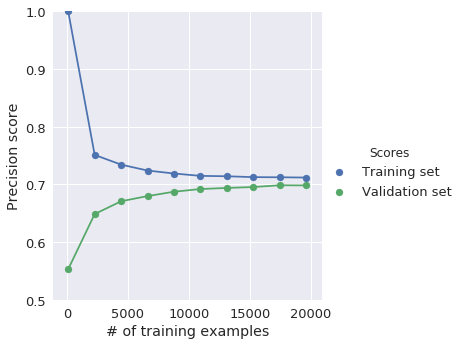

In [29]:
# Initialize a FacetGrid object using the table of scores and facet on
# the score from the different sets
fig = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5
)

# Plot the learning curves, add a legend, and rescale y-axis
fig.map(plt.scatter, '# of training examples', 'Precision score')
fig.map(plt.plot, '# of training examples', 'Precision score') \
    .add_legend() \
    .set(ylim=(0.5, 1));

The learning curves converge quickly to a respectable precision score, indicating the model isn't suffering from high variance and therefore, not overfitting.

<a id="cell7"></a>
## 7. Using nested cross-validation to optimize hyperparameters

We're now ready to optimize the regularization hyperparameter of the model. To do so, without optimistically biasing the model and leaking information about the test set into the training set, let's utilize nested cross-validation.

In [30]:
# Select a range of values to test the regularization hyperparameter
param_grid = [{'C': np.logspace(-3, 3, 10)}]

# Inner cross-validation loop to tune the hyperparameter (a grid search model)
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Outer cross-validation loop to assess model performance
scores = cross_val_score(
    estimator=grid_search,
    X=X_full,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision'
)

# Display cross-validation scores
scores

array([ 0.71032609,  0.70515826,  0.68359788,  0.6961824 ,  0.72182121,
        0.70260223,  0.70352069,  0.70453333,  0.71567436,  0.71368199])

The scores across the different cross-validation folds don't very much&mdash;this is a sign that the model is stable. Let's finish up by computing the average precision score and its standard deviation.

In [31]:
# Display the average precision score
print('Precision: {} +/- {}'.format(scores.mean(), scores.std()))

Precision: 0.705709844650363 +/- 0.010195987511092769


<a id="cell8"></a>
## 8. Training a validated model

To determine the features that were most predictive of funded projects later, we first must identify the optimal regularization hyperparameter as identified by nested cross-validation. Since nested cross-validation doesn't actually train any machine learning models, we have to re-train the cross-validated grid search model and examine the optimal hyperparameter first.

In [32]:
# Train a grid search model to identify the optimal hyperparameter
grid_search.fit(X_full, y_enc)

# Display the optimal hyperparameter
grid_search.best_params_

{'C': 0.021544346900318832}

Let's use this optimal hyperparameter value and train a final model on the entire training set, thus minimizing pessimistic bias.

In [33]:
# Train the classifier on the entire dataset using the optimal hyperparameter
final_clf = LogisticRegression(C=grid_search.best_params_['C'])
final_clf.fit(X_full, y_enc);

We should also save the model that we evaluated without using $n$-grams&mdash;just meta features. We need to go through the same process as above.

In [34]:
# Inner cross-validation loop to tune the hyperparameter (a grid search model)
grid_search2 = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Outer cross-validation loop to assess model performance
scores2 = cross_val_score(
    estimator=grid_search2,
    X=X_std,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision'
)

# Display the average precision score
print('Precision: {} +/- {}'.format(scores2.mean(), scores2.std()))

Precision: 0.6563227813048061 +/- 0.011951550151055024


In [35]:
# Train a grid search model to identify the optimal hyperparameter
grid_search2.fit(X_std, y_enc)

# Train the classifier on the entire dataset using the optimal hyperparameter
final_clf2 = LogisticRegression(C=grid_search2.best_params_['C'])
final_clf2.fit(X_std, y_enc);

<a id="cell9"></a>
## 9. Determining the top predictors of funded projects

We can now examine the top 30 features that were most predictive of funded projects.

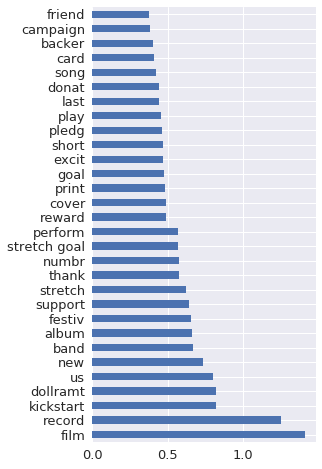

In [36]:
# Combine meta feature labels with n-gram labels
all_features = features + vectorizer.get_feature_names()

# Add the corresponding feature names to the parameters
feature_ranks = pd.Series(
    final_clf.coef_.T.ravel(),
    index=all_features
).sort_values(ascending=False)[:30]

# Display a bar graph of the top 30 features
feature_ranks.plot(kind='barh', legend=False, figsize=(4, 8));

Clearly, there's a lot of contextual features extracted from niche products. Below is a discussion of some of the more interesting ones:

- `dollramt`: This refers to dollar amounts found in the campaign section. Perhaps successful creators are reiterating the pledge awards.
- `new`, `stretch`, `stretch goal`, `reward`, `goal`: These terms make sense since they're appropriate jargon used for campaigns
- `excit`: This is likely the word stem of "exciting", which is an innovation word that I could've included

Since there were no meta features in the top 30, let's examine them separately and see which were the most predictive of funded projects.

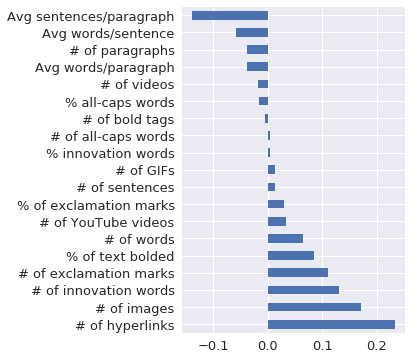

In [37]:
# Add the corresponding meta feature names to the parameters
meta_feature_ranks = pd.Series(
    final_clf.coef_.T.ravel()[:len(features)],
    index=features
).sort_values(ascending=False)

# Display a bar graph of the meta feature importance
meta_feature_ranks.plot(kind='barh', legend=False, figsize=(4, 6));
labels = [
    '# of hyperlinks',
    '# of images',
    '# of innovation words',
    '# of exclamation marks',
    '% of text bolded', 
    '# of words',
    '# of YouTube videos',
    '% of exclamation marks',
    '# of sentences',
    '# of GIFs',
    '% innovation words',
    '# of all-caps words',
    '# of bold tags',
    '% all-caps words',
    '# of videos',
    'Avg words/paragraph',
    '# of paragraphs',
    'Avg words/sentence',
    'Avg sentences/paragraph'    
]
plt.yticks(np.arange(19), labels);

It looks like the top predictor by a wide margin is the # of hyperlinks. Since many successful projects were covered by the news media and the hyperlinks to those articles were included in the campaign, this makes one sense. And my hypothesis about having innovation words was correct! 

Some of the more expected features appeared as strong predictors: bolded text, exclamation marks, innovation words, and images. However, for bolded text, having a high proportion of bold text is better than hitting some absolute count, whereas for images, innovation words and exclamation marks, creators should just go crazy! Finally, length of the campaign was also a good predictor of success.

Surprisingly, all-caps words and GIFs weren't strong predictors. However, my regex for all-caps may have picked up abbreviations. And I guess GIFs don't seem professional and don't build trust.

Some of the best ways to not get funded were to increase sentence/word density and paragraph counts. This is clearly hinting that writing fewer succinct paragraphs and sentences is a good idea!

<a id="cell10"></a>
## 10. Testing Kickstarter pages

For fun, let's engineer features for a sample Kickstarter page, such as the [Pebble 2](https://www.kickstarter.com/projects/getpebble/pebble-2-time-2-and-core-an-entirely-new-3g-ultra), and insert the prepared feature vector and target variable into the trained model to see how it fares with a highly successful project.

In [38]:
# Select a hyperlink
hyperlink = 'https://www.kickstarter.com/projects/getpebble/pebble-2-time-2-and-core-an-entirely-new-3g-ultra'

In [39]:
# Compute the meta features and preprocess the campaign section
meta_features, processed_section = feature_engineering.process_project(
    hyperlink
)

# Compute the n-gram vector from the preprocessed text
ngrams = vectorizer.transform([processed_section])

# Standardize the meta features and convert results into a sparse matrix
scaled_meta_features = sparse.csr_matrix(scaler.transform([meta_features]))

# Concatenate the meta features with the n-gram vector
feature_vector = sparse.hstack([scaled_meta_features, ngrams])

# Display the probability of being funded
final_clf.predict_proba(feature_vector)[0, 1]

0.95769554710282279